# Equivalent circuits
Simple resistor-capacitor (RC) equivalent circuits have been implemented.
### Series RC <img src=rc_series.png>
A resistor and a capacitor are connected in series (denoted $\mathrm{ESR}$ and $\mathrm{C}$ in the figure above).
```
<device>
    <type>              SeriesRC </type>
    <series_resistance>  50.0e-3 </series_resistance> <!-- ohm -->
    <capacitance>         3.0    </capacitance>       <!-- farad -->
</device>
```
Above is the database to build a $3\ \mathrm{F}$ capacitor in series 
with a $50\ \mathrm{m}\Omega$ resistance.

### Parallel RC <img src=rc_parallel.png>
An extra resistance is placed in parallel of the capacitor.
It can be instantiated by the following database.
```
<device>
    <type>                ParallelRC </type>
    <parallel_resistance>     2.5e+6 </parallel_resistance> <!-- ohm -->
    <series_resistance>      50.0e-3 </series_resistance>   <!-- ohm -->
    <capacitance>             3.0    </capacitance>         <!-- farad -->
</device>
```
`type` has been changed from `SeriesRC` to `ParallelRC`.
A $2.5\ \mathrm{M}\Omega$ leakage resistance is specified.

In [1]:
import pycap
import numpy
from matplotlib import pyplot
%matplotlib inline

# Examples
Let us define a simple routine to charge an energy storage device 
at constant voltage $U=1.7\ \mathrm{V}$ for $2 \mathrm{s}$.  
The function `do_constant_voltage_charge` records the current and voltage
during the charge.

In [2]:
U=1.7 # charge potential in volt
t_final=2.0 # final time in second
def do_constant_voltage_charge(device):
    delta_t=0.01 # time step in second
    t=0.0
    time=numpy.array([],dtype=float)
    current=numpy.array([],dtype=float)
    voltage=numpy.array([],dtype=float)
    while t<=t_final:
        t+=delta_t
        device.evolve_one_time_step_constant_voltage(delta_t,U)
        time=numpy.append(time,t)
        current=numpy.append(current,device.get_current())
        voltage=numpy.append(voltage,device.get_voltage())
    return {'time':time,'current':current,'voltage':voltage}

Here is another routine that takes the measurement data and plots the current versus time.

In [3]:
def plot_data(data):
    time=data['time']
    current=data['current']
    voltage=data['voltage']
    label_fontsize=20
    plot_linewidth=2
    pyplot.figure(figsize=(8,6))
    pyplot.plot(time,current,lw=plot_linewidth)
    pyplot.xlabel(r'$\mathrm{Time\ [s]}$',fontsize=label_fontsize)
    pyplot.ylabel(r'$\mathrm{Current\ [A]}$',fontsize=label_fontsize)
    pyplot.show()

### Series RC

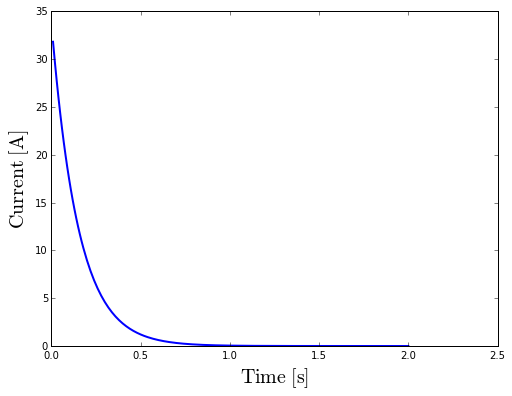

In [4]:
R=50.0e-3 # ohm
C=3.0 # farad

# initiate a database
device_database=pycap.PropertyTree()
# fill it
device_database.put_string('device.type','SeriesRC')
device_database.put_double('device.series_resistance',R)
device_database.put_double('device.capacitance',C)
# build an energy storage device
device=pycap.EnergyStorageDevice(device_database)
# charge it
data=do_constant_voltage_charge(device)
# plot the data
plot_data(data)

The exact solution for the current is
\begin{equation}
i_{exact} = \frac{U}{R} e^{-t / RC}
\end{equation}

The error is computed as
$100 \times \left\|\frac{i_{computed}-i_{exact}}{i_{computed}}\right\|_\infty$

In [5]:
t=data['time']
i_computed=data['current']
# compute the exact answer
i_exact=U/R*numpy.exp(-t/(R*C))
# ensure that the error is small
error_norm=100*numpy.linalg.norm((i_computed-i_exact)/i_computed,numpy.inf)
percent_tolerance=1.0e-4
print 'max percent error = %e'%error_norm
assert error_norm<percent_tolerance

max percent error = 6.014144e-09


### Parallel RC

In [6]:
# database can also be filled by parsing an input file
device_database=pycap.PropertyTree()
device_database.parse_xml('parallel_rc.xml')
# build the corresponding energy storage device
device=pycap.EnergyStorageDevice(device_database)
# make sure device type is a parallel RC circuit
assert device_database.get_string('device.type')=='ParallelRC'
# get the parameter values to compare to the exact solution
C=device_database.get_double('device.capacitance')
R=device_database.get_double('device.series_resistance')
R_L=device_database.get_double('device.parallel_resistance')
# charge the device
data=do_constant_voltage_charge(device)

The exact answer is given by
\begin{equation}
i_{exact}=\frac{U}{R} (1 - \frac{R_L}{R+R_L} (1 - e^{-t / \frac{R R_L}{R+R_L}C})
\end{equation}


In [7]:
# extract the data
t=data['time']
i_computed=data['current']
# compute the exact answer
i_exact=U/R*(1+R_L/(R+R_L)*numpy.expm1(-t/(R*R_L/(R+R_L)*C)))
# ensure that the error is small
error_norm=100*numpy.linalg.norm((i_computed-i_exact)/i_computed,numpy.inf)
percent_tolerance=1.0e-4
print 'max percent error = %e'%error_norm
assert error_norm<percent_tolerance

max percent error = 1.634168e-08
